Scoring in next 10 actions model - Model Evaluation - GBM

In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/")

In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from exp_vaep.config import exp_vaep_modelling_file_path
from exp_vaep.domain.contracts.modelling_data_contract import ModellingDataContract
from exp_vaep.domain.modelling.supermodel import SuperXGBRegressor
from exp_vaep.domain.modelling.model_evaluation import XGBRegressorEvaluator
from exp_vaep.domain.preprocessing.preprocessing import *

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


New Model

In [3]:
new_version = 1
model_name = "exp_vaep_conceding"
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/exp_vaep/model_outputs/models/"
preproc_file_path = ""

Comparison Model

In [4]:
old_version = new_version - 1
compare_train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/exp_vaep/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(old_version)+".csv"
compare_test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/exp_vaep/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(old_version)+".csv"

Response

In [5]:
RESPONSE = ModellingDataContract.RESPONSE_CONCEDES

Features

In [6]:
FEATURES = ModellingDataContract.feature_list_scores

Load Data

In [7]:
modelling_data = pd.read_csv(exp_vaep_modelling_file_path)
modelling_data.tail()

,match_id,quarter,quarter_seconds,overall_seconds,team,player,start_x,start_y,end_x,end_y,action_type,outcome_type,xScore,type_Kick_a0,type_Handball_a0,type_Carry_a0,type_Uncontested Mark_a0,type_Contested Mark_a0,type_Loose Ball Get_a0,type_Hard Ball Get_a0,type_Spoil_a0,type_Gather_a0,type_Free For_a0,type_Knock On_a0,type_Shot_a0,type_Tackle_a0,type_Error_a0,outcome_effective_a0,outcome_ineffective_a0,outcome_clanger_a0,type_Kick_outcome_effective_a0,type_Kick_outcome_ineffective_a0,type_Kick_outcome_clanger_a0,type_Handball_outcome_effective_a0,type_Handball_outcome_ineffective_a0,type_Handball_outcome_clanger_a0,type_Carry_outcome_effective_a0,type_Carry_outcome_ineffective_a0,type_Carry_outcome_clanger_a0,type_Uncontested Mark_outcome_effective_a0,type_Uncontested Mark_outcome_ineffective_a0,type_Uncontested Mark_outcome_clanger_a0,type_Contested Mark_outcome_effective_a0,type_Contested Mark_outcome_ineffective_a0,type_Contested Mark_outcome_clanger_a0,type_Loose Ball Get_outcome_effective_a0,type_Loose Ball Get_outcome_ineffective_a0,type_Loose Ball Get_outcome_clanger_a0,type_Hard Ball Get_outcome_effective_a0,type_Hard Ball Get_outcome_ineffective_a0,type_Hard Ball Get_outcome_clanger_a0,type_Spoil_outcome_effective_a0,type_Spoil_outcome_ineffective_a0,type_Spoil_outcome_clanger_a0,type_Gather_outcome_effective_a0,type_Gather_outcome_ineffective_a0,type_Gather_outcome_clanger_a0,type_Free For_outcome_effective_a0,type_Free For_outcome_ineffective_a0,type_Free For_outcome_clanger_a0,type_Knock On_outcome_effective_a0,type_Knock On_outcome_ineffective_a0,type_Knock On_outcome_clanger_a0,type_Shot_outcome_effective_a0,type_Shot_outcome_ineffective_a0,type_Shot_outcome_clanger_a0,type_Tackle_outcome_effective_a0,type_Tackle_outcome_ineffective_a0,type_Tackle_outcome_clanger_a0,type_Error_outcome_effective_a0,type_Error_outcome_ineffective_a0,type_Error_outcome_clanger_a0,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,type_Kick_a1,type_Handball_a1,type_Carry_a1,type_Uncontested Mark_a1,type_Contested Mark_a1,type_Loose Ball Get_a1,type_Hard Ball Get_a1,type_Spoil_a1,type_Gather_a1,type_Free For_a1,type_Knock On_a1,type_Shot_a1,type_Tackle_a1,type_Error_a1,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,type_Kick_outcome_effective_a1,type_Kick_outcome_ineffective_a1,type_Kick_outcome_clanger_a1,type_Handball_outcome_effective_a1,type_Handball_outcome_ineffective_a1,type_Handball_outcome_clanger_a1,type_Carry_outcome_effective_a1,type_Carry_outcome_ineffective_a1,type_Carry_outcome_clanger_a1,type_Uncontested Mark_outcome_effective_a1,type_Uncontested Mark_outcome_ineffective_a1,type_Uncontested Mark_outcome_clanger_a1,type_Contested Mark_outcome_effective_a1,type_Contested Mark_outcome_ineffective_a1,type_Contested Mark_outcome_clanger_a1,type_Loose Ball Get_outcome_effective_a1,type_Loose Ball Get_outcome_ineffective_a1,type_Loose Ball Get_outcome_clanger_a1,type_Hard Ball Get_outcome_effective_a1,type_Hard Ball Get_outcome_ineffective_a1,type_Hard Ball Get_outcome_clanger_a1,type_Spoil_outcome_effective_a1,type_Spoil_outcome_ineffective_a1,type_Spoil_outcome_clanger_a1,type_Gather_outcome_effective_a1,type_Gather_outcome_ineffective_a1,type_Gather_outcome_clanger_a1,type_Free For_outcome_effective_a1,type_Free For_outcome_ineffective_a1,type_Free For_outcome_clanger_a1,type_Knock On_outcome_effective_a1,type_Knock On_outcome_ineffective_a1,type_Knock On_outcome_clanger_a1,type_Shot_outcome_effective_a1,type_Shot_outcome_ineffective_a1,type_Shot_outcome_clanger_a1,type_Tackle_outcome_effective_a1,type_Tackle_outcome_ineffective_a1,type_Tackle_outcome_clanger_a1,type_Error_outcome_effective_a1,type_Error_outcome_ineffective_a1,type_Error_outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,type_Kick_a2,type_Handball_a2,type_Carry_a2,type_Uncontested Mark_a2,type_Cont

Preprocess Data

In [8]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train_preproc = preprocessor.transform(X_train)
# X_test_preproc = preprocessor.transform(X_test)

In [9]:
training_data = modelling_data[modelling_data[RESPONSE+"TrainingSet"]]
test_data = modelling_data[modelling_data[RESPONSE+"TestSet"]]
cal_data = modelling_data[modelling_data[RESPONSE+"ValidationSet"]]

In [10]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]
X_cal, y_cal = cal_data.drop(columns=[RESPONSE]), cal_data[RESPONSE]

In [11]:
y_train.mean(), y_test.mean(), y_cal.mean()

(0.16476937483949003, 0.16462848910445474, 0.16308635116629228)

In [12]:
X_train_preproc = X_train[FEATURES]
X_test_preproc = X_test[FEATURES]
X_cal_preproc = X_cal[FEATURES]

Load Model

In [13]:
super_xgb = joblib.load(model_file_path + "/" + model_name + "_v" + str(new_version) + ".joblib")

Get Predictions

In [14]:
train_preds = super_xgb.predict(X_train_preproc)
test_preds = super_xgb.predict(X_test_preproc)

Compare Model

In [15]:
# compare_train_data = pd.read_csv(compare_train_predictions_file_path)
# compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [16]:
# compare_train_data = compare_train_data.rename(columns = {'xgb_preds_exp_scores':'old_preds'})
# compare_test_data = compare_test_data.rename(columns = {'xgb_preds_exp_scores':'old_preds'})

In [17]:
# training_data.shape, compare_train_data.shape, test_data.shape, compare_test_data.shape

In [18]:
# compare_test_data.head()

In [19]:
# training_data = pd.merge(training_data, compare_train_data[["match_id", "quarter", "quarter_seconds", "overall_seconds", "team", "player", 'start_x', 'start_y', 'end_x', 'end_y', "action_type", "outcome_type", "xScore", 'old_preds']], how = "left", on = ["match_id", "quarter", "quarter_seconds", "overall_seconds", "team", "player", 'start_x', 'start_y', 'end_x', 'end_y', "action_type", "outcome_type", "xScore",])
# test_data = pd.merge(test_data, compare_test_data[["match_id", "quarter", "quarter_seconds", "overall_seconds", "team", "player", 'start_x', 'start_y', 'end_x', 'end_y', "action_type", "outcome_type", "xScore", 'old_preds']], how = "left", on = ["match_id", "quarter", "quarter_seconds", "overall_seconds", "team", "player", 'start_x', 'start_y', 'end_x', 'end_y', "action_type", "outcome_type", "xScore",])

Evaluate Model

In [20]:
training_data['xgb_preds'] = train_preds

train_xgb_evals = XGBRegressorEvaluator(model = super_xgb,
                                       data = training_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_preds",
                                    #    compare_name='old_preds',
                                       )


In [21]:
test_data['xgb_preds'] = test_preds

test_xgb_evals = XGBRegressorEvaluator(model = super_xgb,
                                       data = test_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_preds",
                                    #    compare_name = "old_preds",
                                       )

Model Averages

In [22]:
training_data[[RESPONSE, 'xgb_preds']].describe()

,exp_concedes,xgb_preds
count,606647.000000,606647.000000
mean,0.164769,0.164903
std,0.748022,0.215513
min,0.000000,-0.662846
25%,0.000000,0.053525
50%,0.000000,0.093242
75%,0.000000,0.200125
max,5.739078,3.252530


In [23]:
test_data[[RESPONSE, 'xgb_preds']].describe()

,exp_concedes,xgb_preds
count,189578.000000,189578.000000
mean,0.164628,0.165917
std,0.748059,0.215631
min,0.000000,-0.634353
25%,0.000000,0.053633
50%,0.000000,0.093720
75%,0.000000,0.202302
max,5.739078,2.961670


Plots

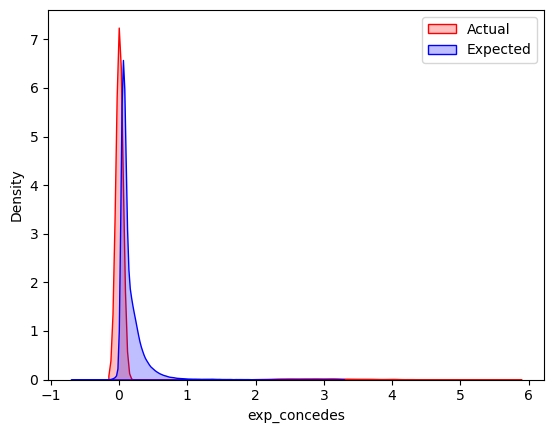

In [24]:
train_xgb_evals.plot_distribution()

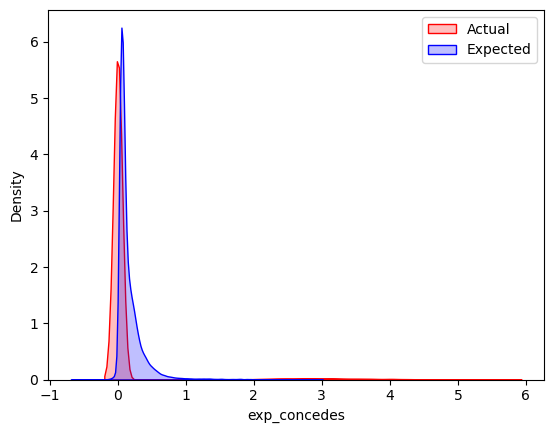

In [25]:
test_xgb_evals.plot_distribution()

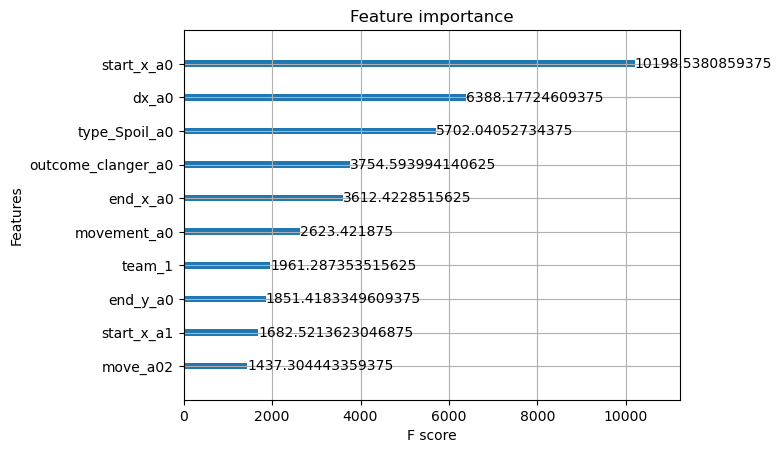

In [26]:
train_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

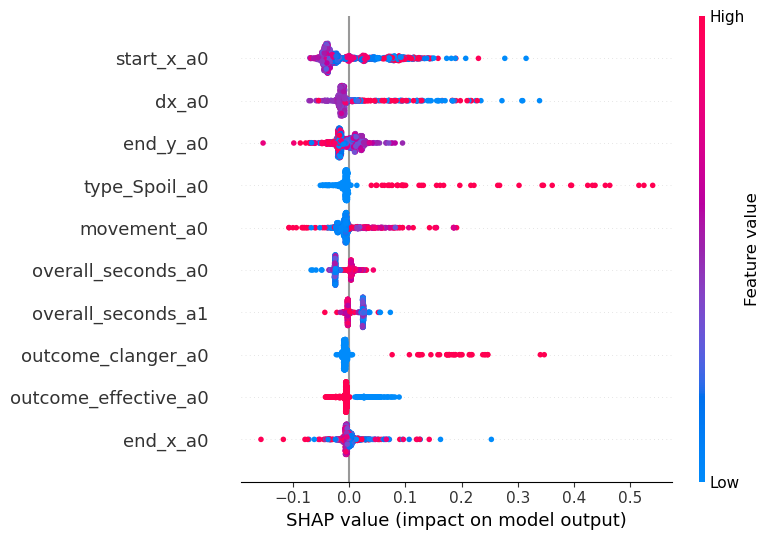

In [27]:
train_xgb_evals.plot_shap_summary_plot(sample=1000)

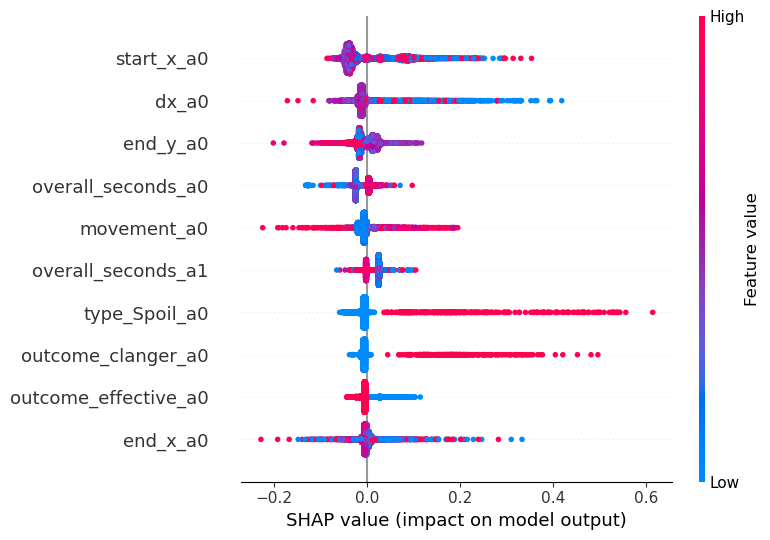

In [28]:
test_xgb_evals.plot_shap_summary_plot(sample=10000)

In [29]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['start_x_a0',
 'dx_a0',
 'end_y_a0',
 'overall_seconds_a0',
 'movement_a0',
 'overall_seconds_a1',
 'type_Spoil_a0',
 'outcome_clanger_a0',
 'outcome_effective_a0',
 'end_x_a0']

In [30]:
# for col in top_10_features:
#     test_xgb_evals.plot_pdp([col])

In [31]:
# for col in top_10_features:
#     train_xgb_evals.plot_ice([col])
#     test_xgb_evals.plot_ice([col])

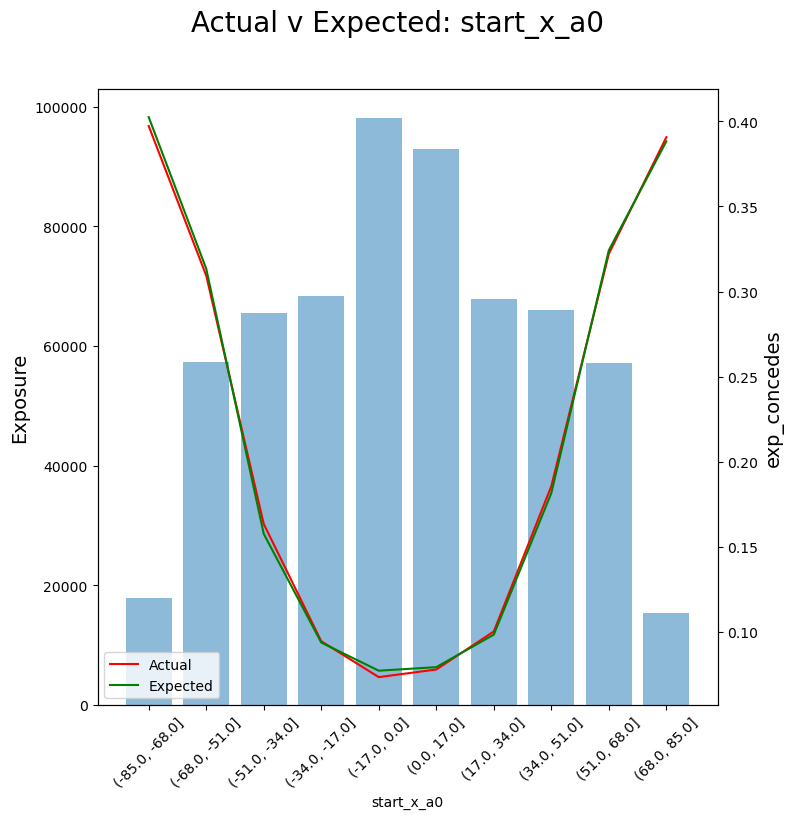

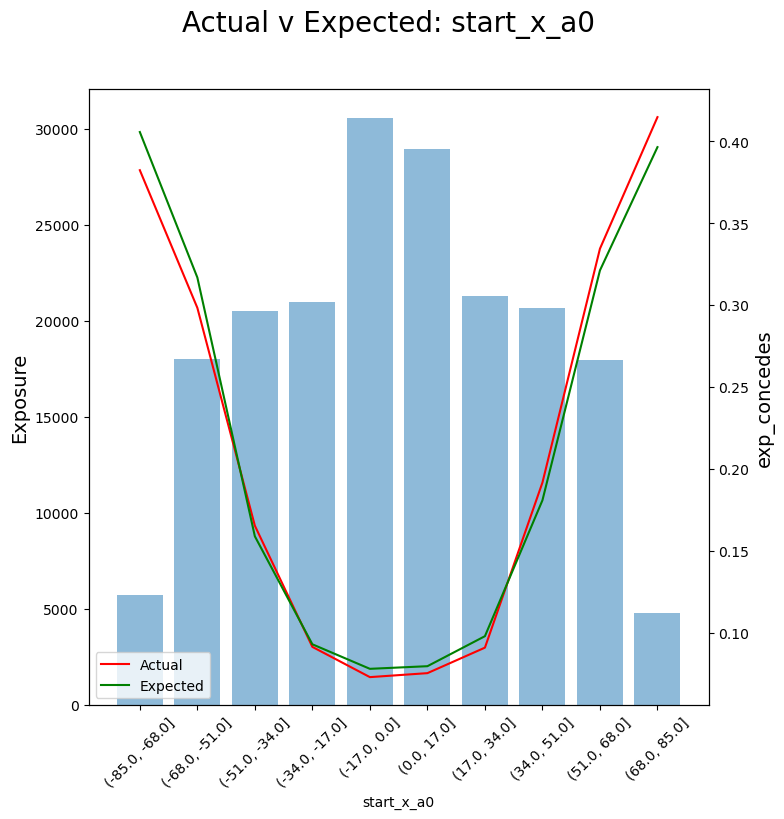

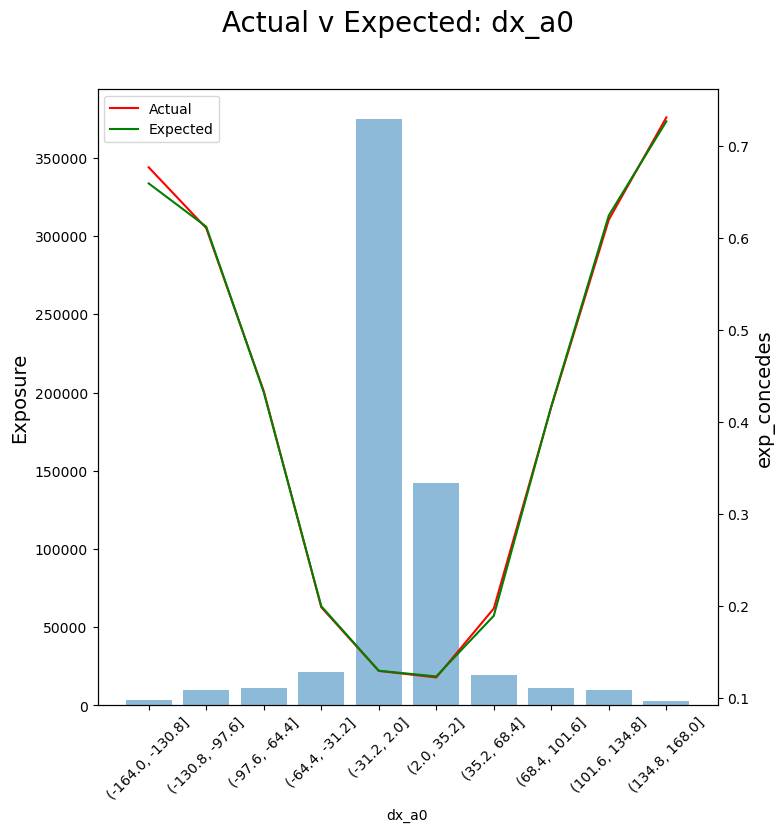

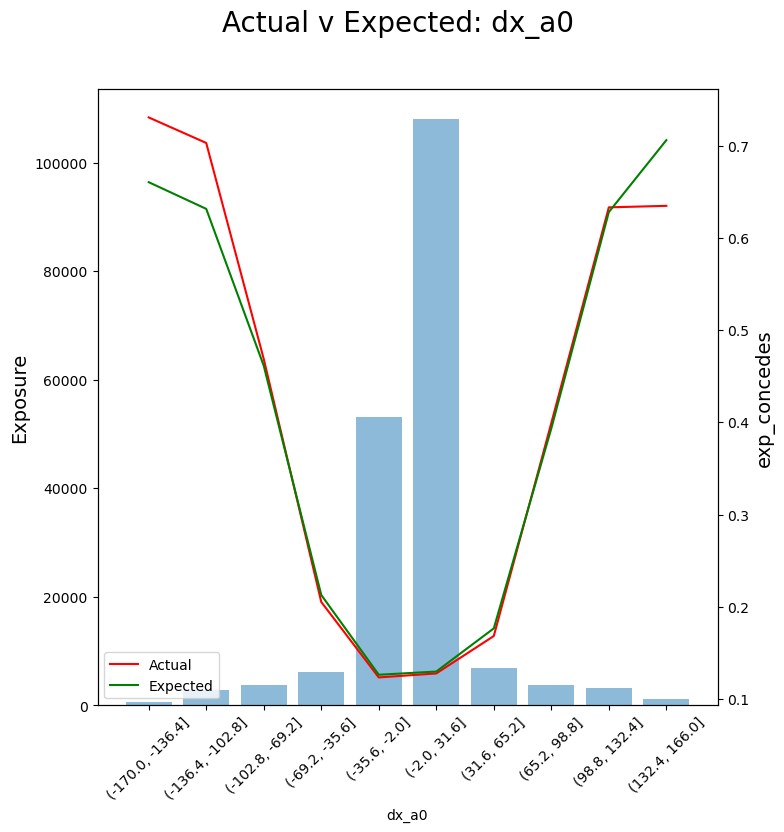

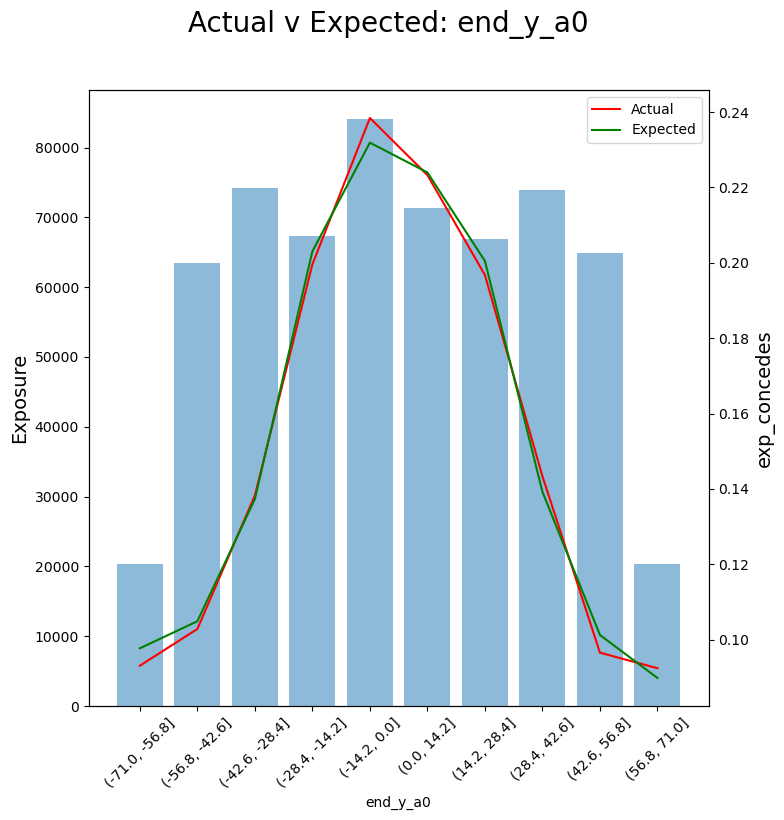

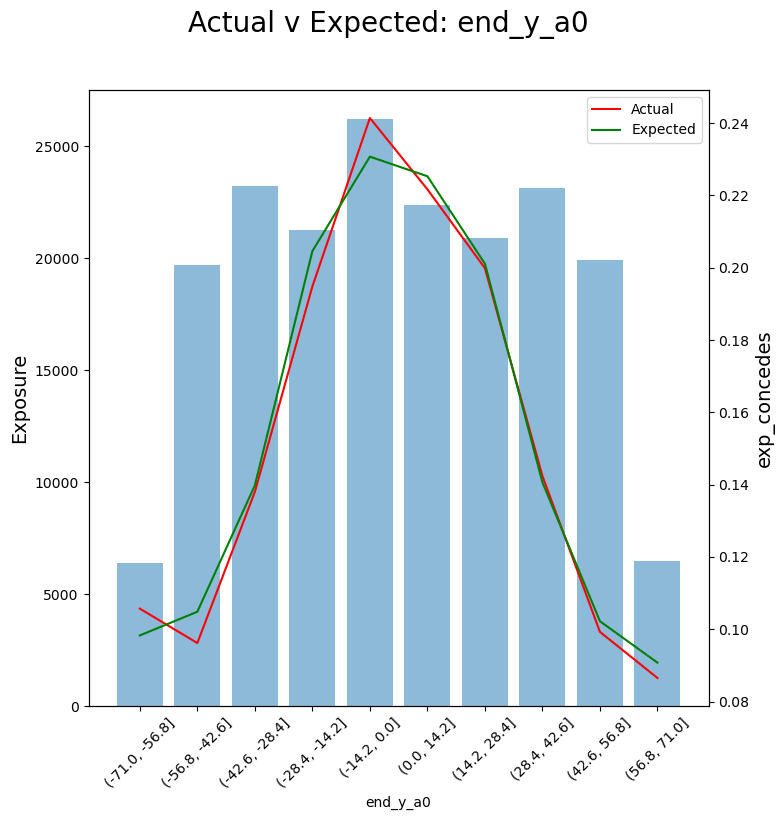

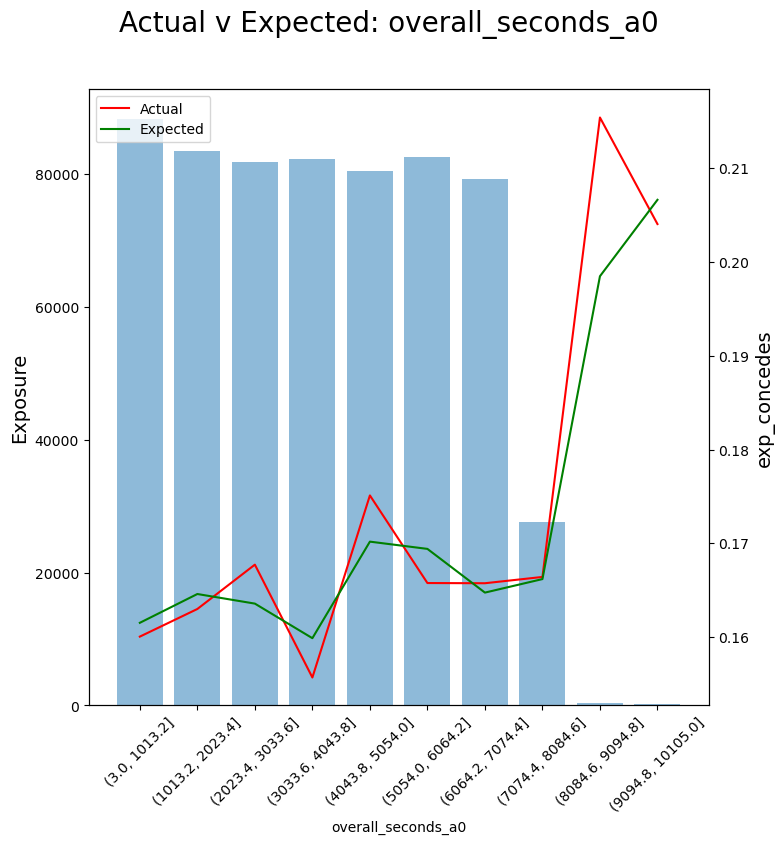

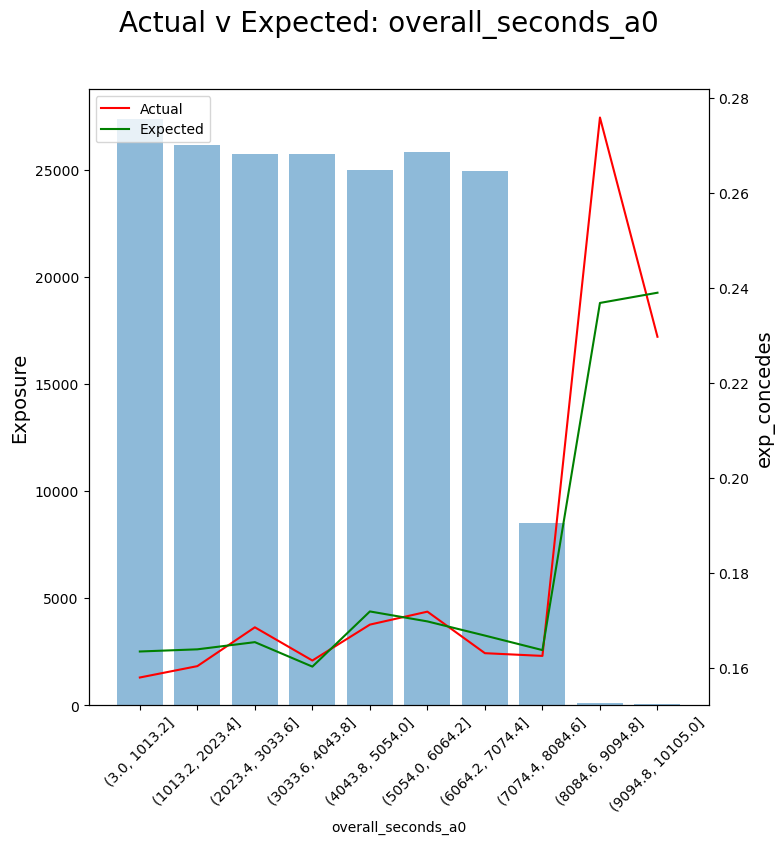

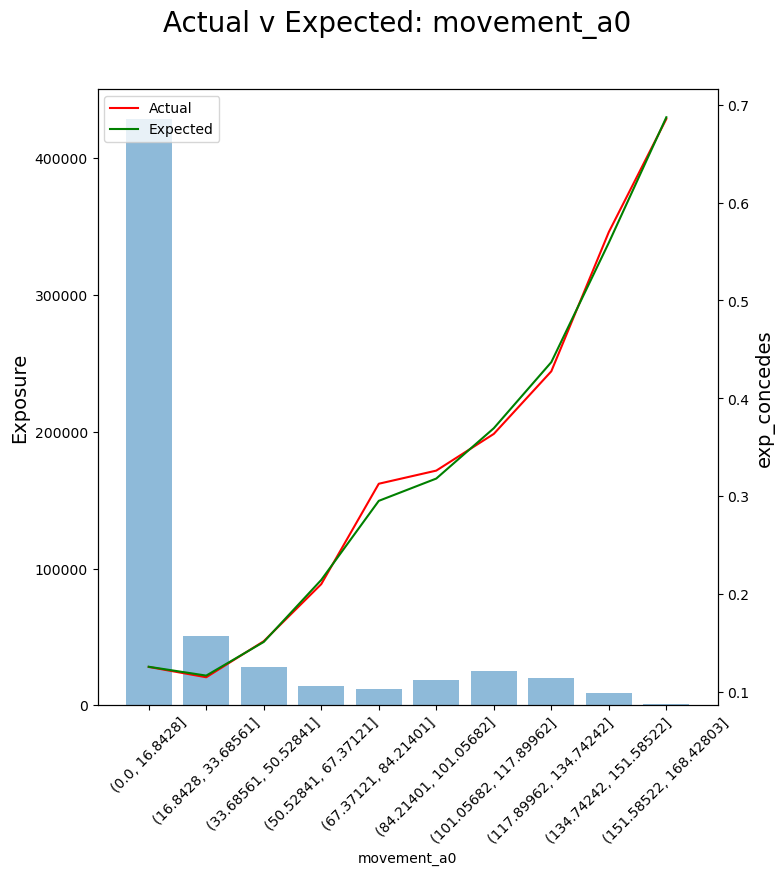

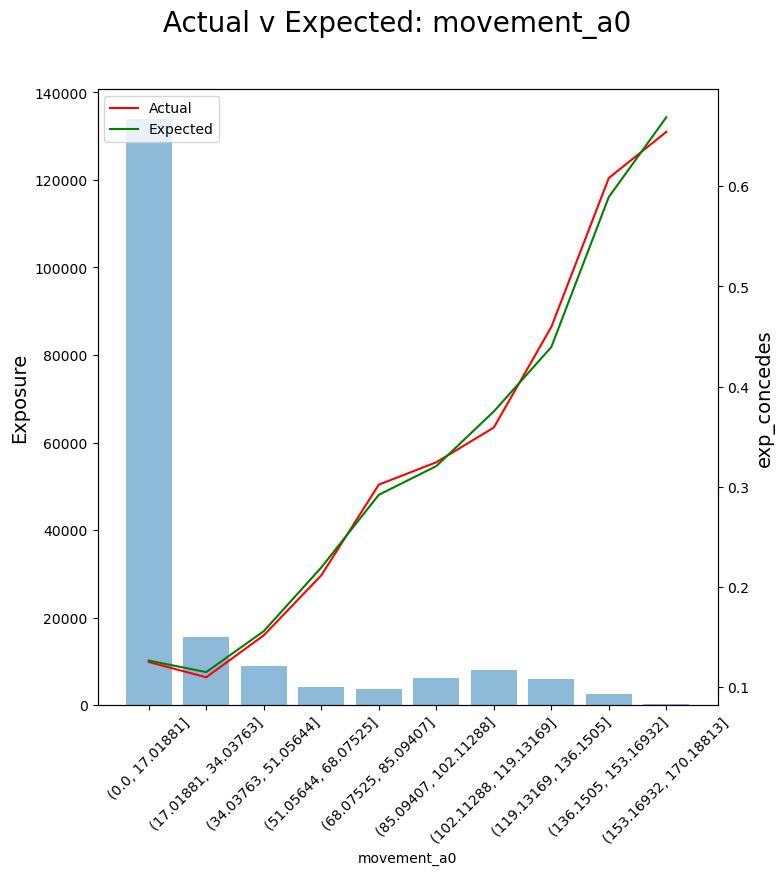

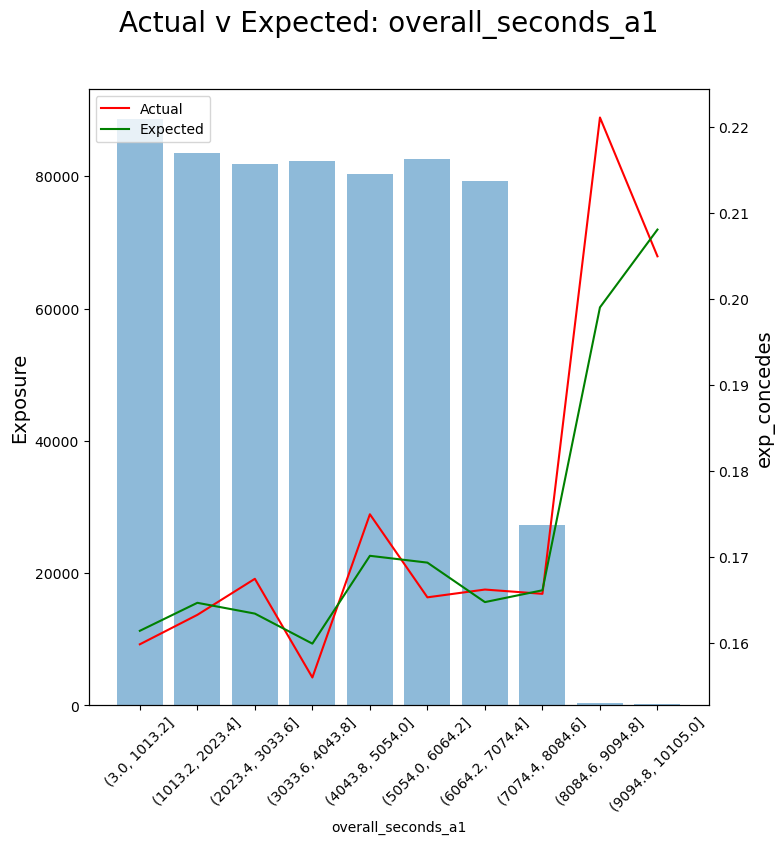

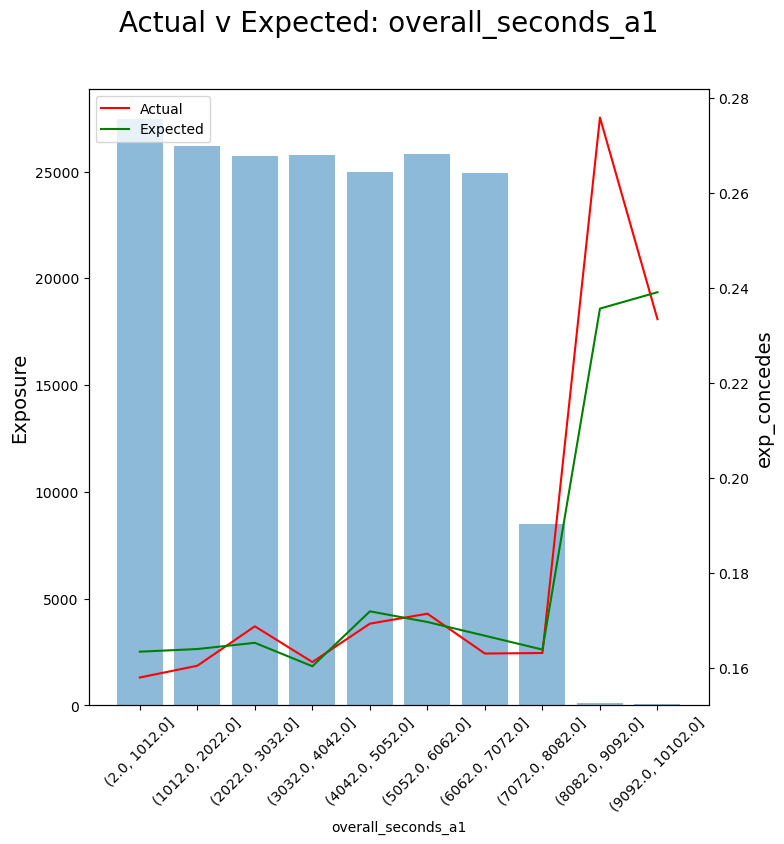

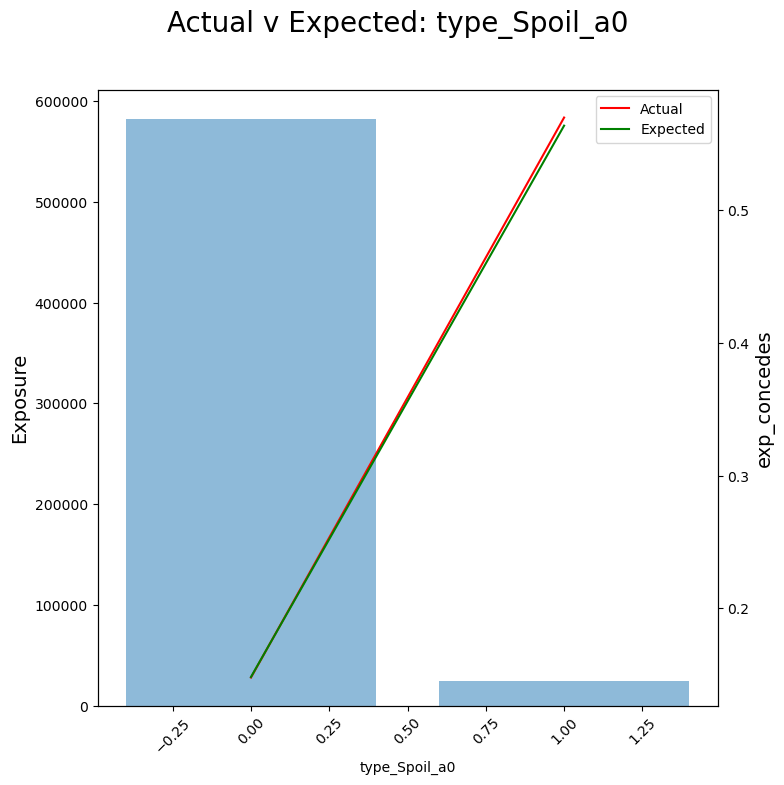

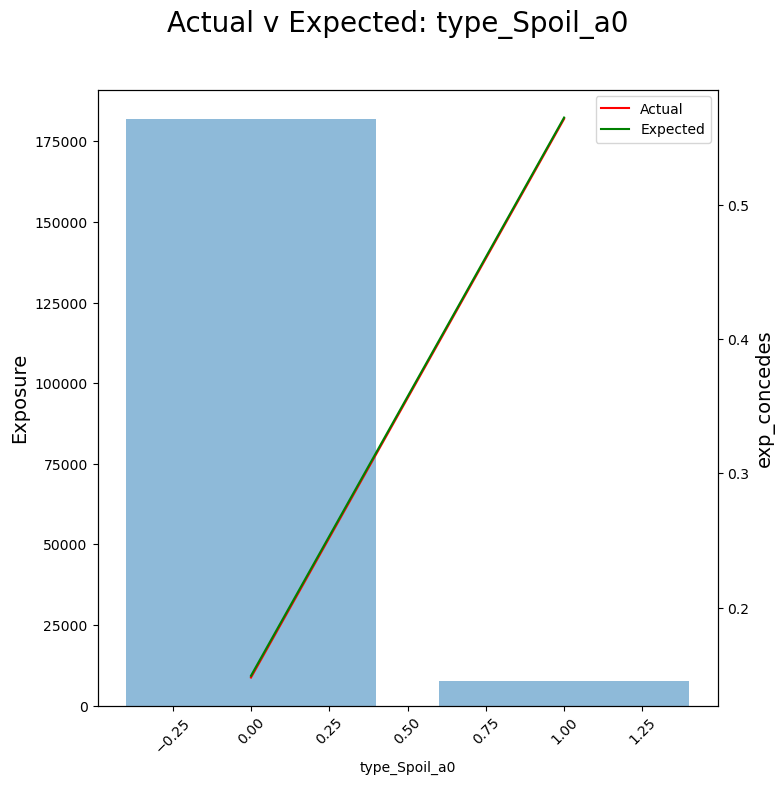

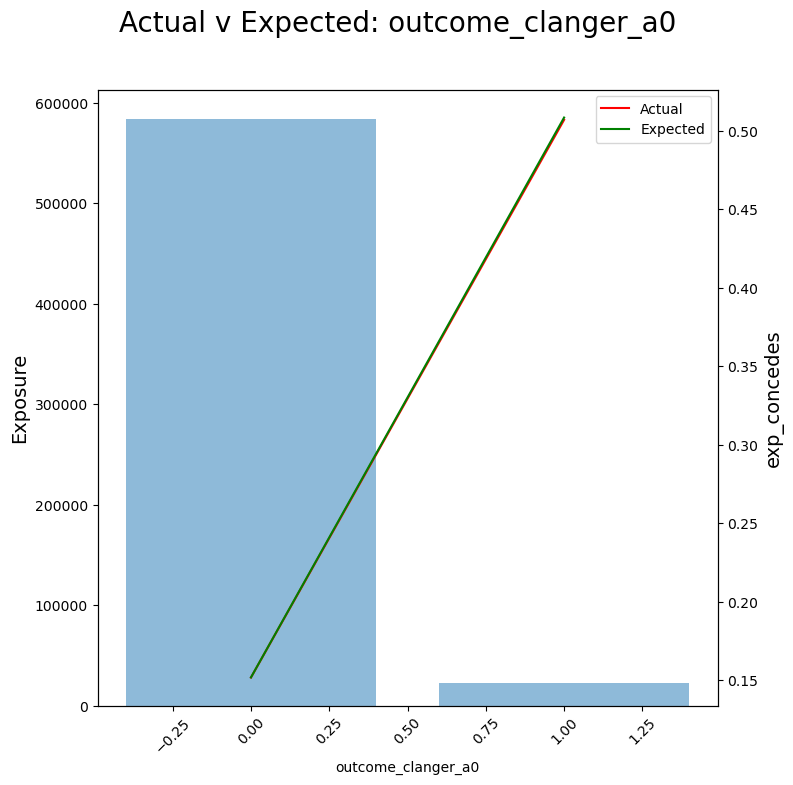

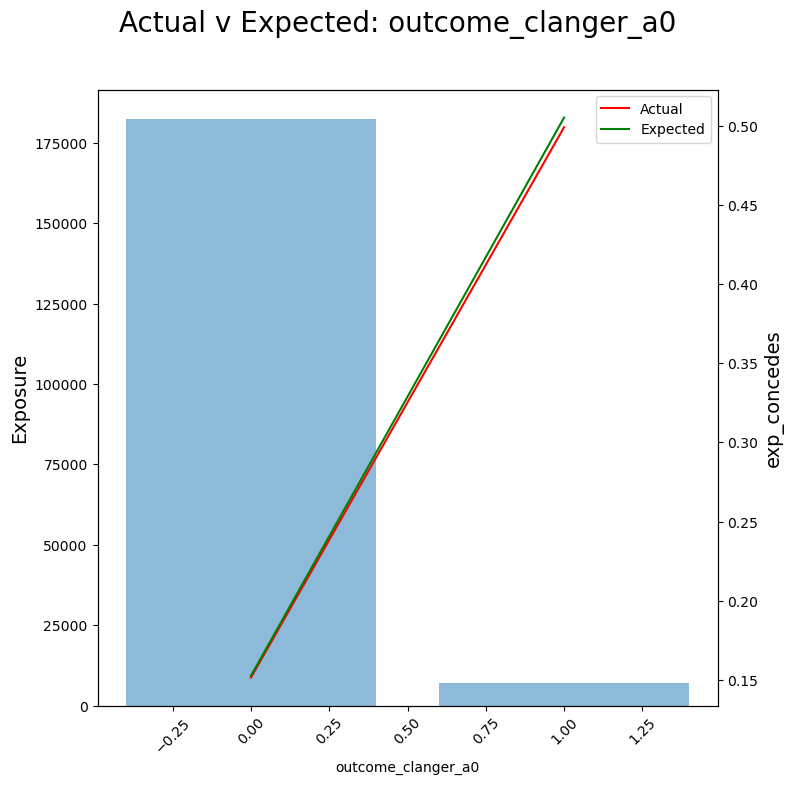

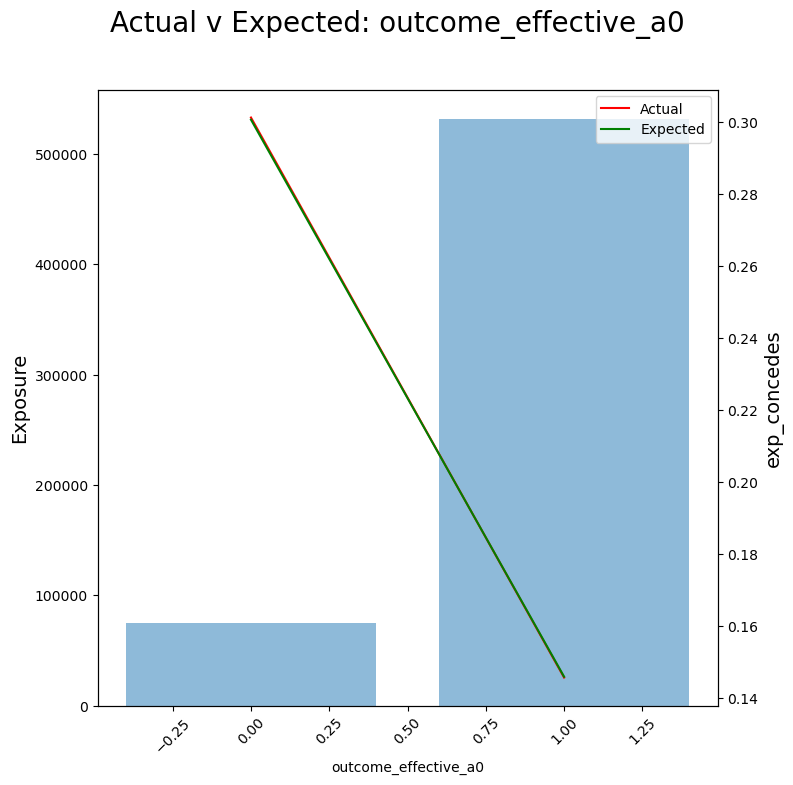

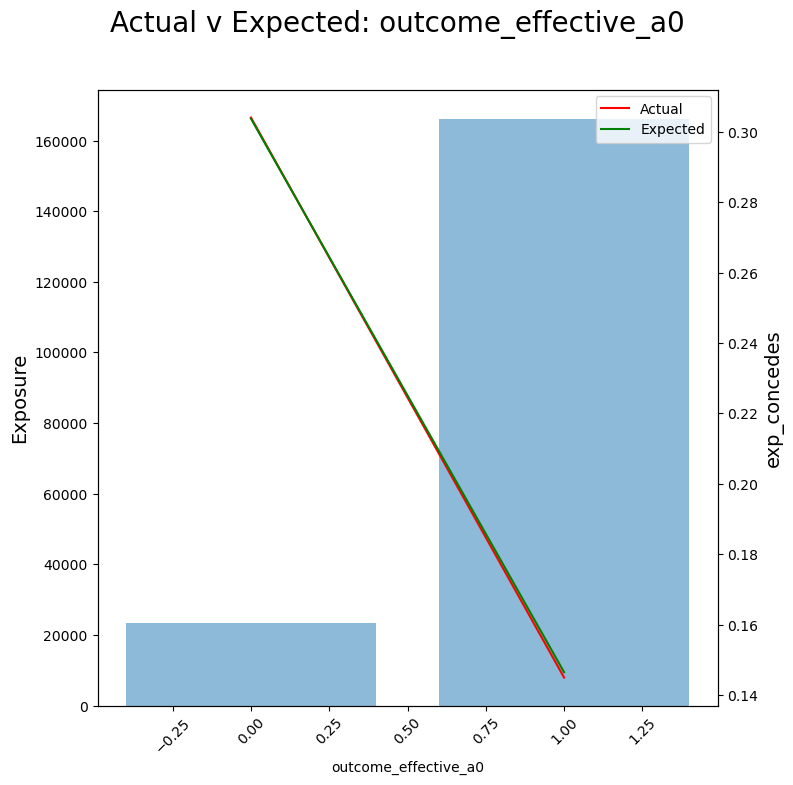

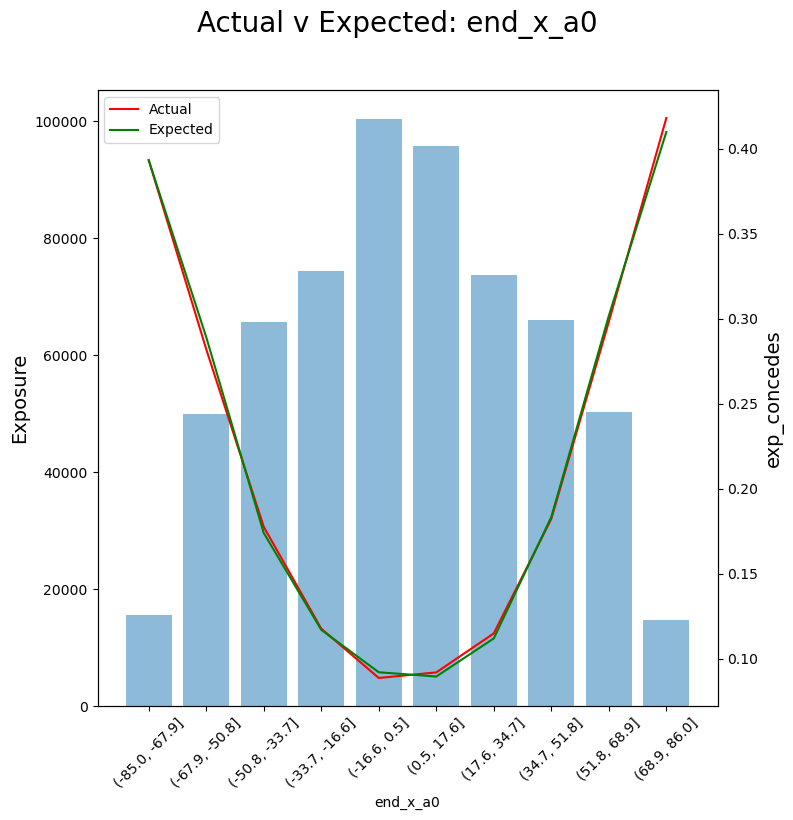

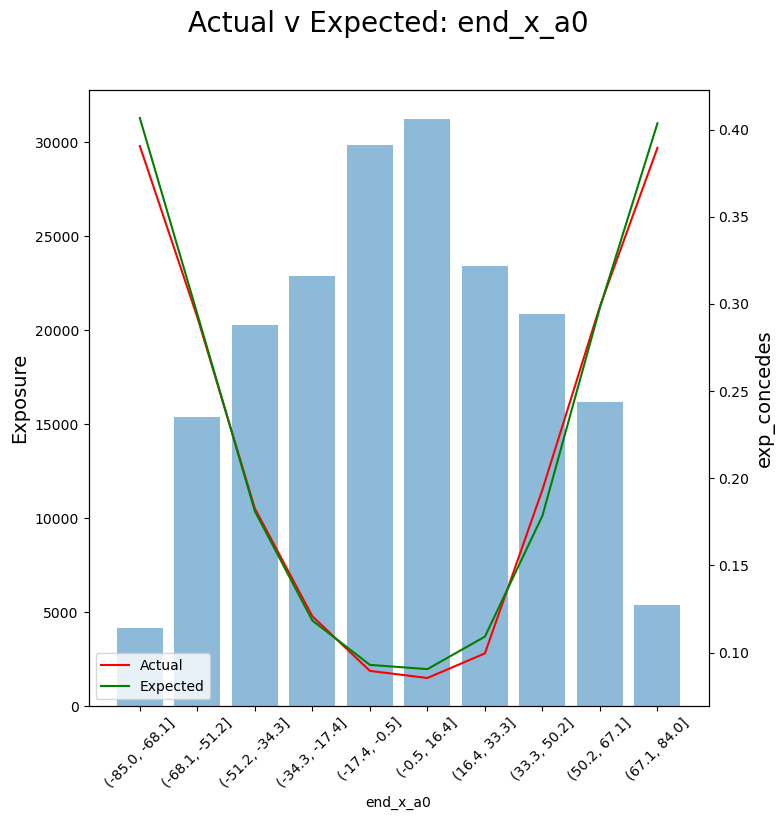

In [32]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [33]:
train_xgb_evals.get_mae(), test_xgb_evals.get_mae()

(0.2831528314726493, 0.2870494317122101)

In [34]:
train_xgb_evals.get_mse(), test_xgb_evals.get_mse() 

(0.5012327287526451, 0.5116596257948541)

In [35]:
train_xgb_evals.get_r2_score(), test_xgb_evals.get_r2_score() 

(0.10419940368341118, 0.08565270401220959)